# Multicolinealidad

En el tema 9 estuvimos viendo varios problemas que podíamos resolver usando regresión lineal. Por ejemplo:

- Nos ayuda a identificar asociaciones falsas.
- Nos ayuda a identificar relaciones enmascaradas.

Vimos que todo esto lo logramos incluyendo **más predictores** en la regresión, por lo que nos podríamos llevar la **falsa idea** de *agregar todo a la regresión y ver qué pasa*. Desafortunadamente, nuestro modelo no siempre nos dirá que pasa de forma correcta, y es porque le lanzamos preguntas incorrectas.

Por eso, en este tema estaremos viendo qué cosas *malas* pueden pasar cuando simplemente añadimos más predictores a nuestra regresión. Veremos tres dificultades:
- Multicolinealidad,
- Bias de post-tratamiento,
- Bias de colisión.

> **Objetivos:**
> - Entender el problema de multicolinealidad.


> **Referencias:**
> 
> - Statistical Rethinking: A Bayesian Course with Examples in R and Stan (2nd edition) - Richard McElreath.

## 1. Multicolinealidad

El caso más común es tener varios predictores para un modelo de regresión. Por ejemplo, en los datos de la leche en diferentes especies:

In [1]:
# Importar pandas
import pandas as pd

In [2]:
# Leer milk data
milk_data = pd.read_csv(
    "data/milk.csv",
    sep=";"
)
milk_data.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


Observamos que para predecir el contenido energético, tenemos siete (7) posibles predictores. ¿Porqué no simplemente incluirlos todos?

El primer problema, y quizá el menos nocivo, que nos podemos encontrar es el de **multicolinealidad**. La multicolinealidad significa una asociación fuerte entre dos o más predictores.

> En muchos cursos y blogs, probablemente han visto/escuchado hablar de este tema, y es común como estrategia de selección de predictores, descartar variables altamente correlacionadas. Desde nuestro punto de vista, la pura correlación no importa. Lo que importa en realidad es la **asociación**, condicionada a las demás variables en el modelo.

La consecuencia de la multicolinealidad es que la distribución posterior nos sugerirá potencialmente que ninguna de las variables colineales se asocia realmente con la variable resultado, **incluso si todas estas variables están fuertemente asociadas con la variable resultado.**

Hablábamos de que este es quizá el problema menos nocivo, porque en realidad no es un problema. Simplemente es un reflejo de como funciona la regresión lineal. En realidad, en presencia de multicolinealidad, nuestro modelo será bueno haciendo predicciones. Lo que nos dará un poco más de dificultades es entender el modelo.

Veamos una simple simulación para entender esto:

In [3]:
# Importar scipy.stats norm & uniform
from scipy.stats import norm, uniform

In [4]:
uniform?

Signature:       uniform(*args, **kwds)
Type:            uniform_gen
String form:     <scipy.stats._continuous_distns.uniform_gen object at 0x7fa1c230f7f0>
File:            ~/anaconda3/envs/stat-rethink2-pymc_v4/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py
Docstring:      
A uniform continuous random variable.

In the standard form, the distribution is uniform on ``[0, 1]``. Using
the parameters ``loc`` and ``scale``, one obtains the uniform distribution
on ``[loc, loc + scale]``.

As an instance of the `rv_continuous` class, `uniform` object inherits from it
a collection of generic methods (see below for the full list),
and completes them with details specific for this particular distribution.

Methods
-------
rvs(loc=0, scale=1, size=1, random_state=None)
    Random variates.
pdf(x, loc=0, scale=1)
    Probability density function.
logpdf(x, loc=0, scale=1)
    Log of the probability density function.
cdf(x, loc=0, scale=1)
    Cumulative distribution function.
logc

In [6]:
# Número de individuos
n_ind = 100
# Simulación de la altura del individuo ~ N(170, 20)
height = norm.rvs(size=n_ind, loc=1.7, scale=0.2)
# Simulación de la proporción del tamaño de pierna ~ U(0.4, 0.5)
leg_proportion = uniform.rvs(size=n_ind, loc=0.4, scale=0.1)
# Simulación de los tamaños de pierna = proporción + error
left_leg = leg_proportion * height + norm.rvs(size=n_ind, loc=0, scale=0.005)
right_leg = leg_proportion * height + norm.rvs(size=n_ind, loc=0, scale=0.005)
# Dataframe
leg_data = pd.DataFrame({
    "height": height,
    "left_leg": left_leg,
    "right_leg": right_leg
})

In [7]:
# Overview de los datos
leg_data

,height,left_leg,right_leg
0,1.834076,0.800083,0.798090
1,1.824625,0.814039,0.803641
2,1.767656,0.734251,0.724058
3,1.841579,0.796429,0.822168
4,1.480443,0.599544,0.604149
...,...,...,...
95,1.389921,0.652427,0.642848
96,1.571187,0.672371,0.669304
97,1.998318,0.821147,0.822697
98,1.916207,0.922028,0.911079


Estos datos pretenden simular la altura de uan persona y el tamaño de ambas piernas. Se supone que el tamaño de las piernas es proporcional a la altura, pero cada pierna puede ser diferente de la otra por una pequeña cantidad.

Ahora, generemos un modelo para intentar predecir la altura usando los tamaños de ambas piernas como predictores. ¿Qué podríamos esperar?

- En promedio, la proporción del tamaño de piernas respecto a la altura es del 45% en estos datos simulados.
- Por tanto esperaríamos ver los coeficientes de regresión al rededor de $\frac{170}{170 \times 0.45} \approx 2.2$.

Veamos que pasa en su lugar:

In [8]:
# Importar pymc y arviz
import pymc as pm
import arviz as az

In [14]:
# Modelo
with pm.Model() as height_model:
    a = pm.Normal("a", mu=1.7, sigma=2)
    bleft = pm.Normal("bl", mu=2, sigma=10)
    bright = pm.Normal("br", mu=2, sigma=10)
    sigma = pm.Exponential("sigma", 1)
    mu = a + bleft * left_leg + bright * right_leg
    height = pm.Normal(
        "height",
        mu=mu,
        sigma=sigma,
        observed=leg_data["height"]
    )
    idata_multicol = pm.sample(draws=100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bl, br, sigma]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 33 seconds.


In [15]:
# Summary
az.summary(
    idata_multicol,
    kind="stats",
    hdi_prob=0.89,
    var_names=["a", "bl", "br", "sigma"]
)

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.458,0.088,0.319,0.597
bl,0.528,1.122,-1.346,2.192
br,1.081,1.125,-0.604,2.917
sigma,0.091,0.007,0.081,0.102


array([<Axes: title={'center': '89.0% HDI'}>], dtype=object)

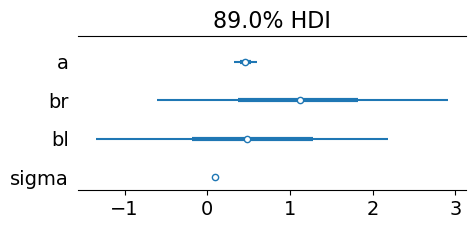

In [16]:
# Plot forest
az.plot_forest(
    idata_multicol,
    var_names=["a", "br", "bl", "sigma"],
    combined=True,
    figsize=[5, 2],
    hdi_prob=0.89
)

Observamos que en la distribución posterior, tanto las medias como las desviaciones estándar no coinciden para nada con nuestra intuición.

Incluso, simulando nuevos datos, aunque observemos que los datos son relativamente similares, las posteriores cambian bastante.

Esto no quiere decir que nuestro modelo esté fallando. Simplemente, nos está entregando la posterior correspondiente a la pregunta que le hicimos. La pregunta es: *¿Cuál es el valor de conocer cada tamaño de la pierna, si ya conocemos el otro?*

Veamos un gráfico de dispersión de puntos de $bl$ vs. $br$, y la densidad de la suma $bl + br$:

In [17]:
# Dataframe con muestras de la posterior
posterior_df = idata_multicol.posterior.to_dataframe().reset_index()
posterior_df

,chain,draw,a,bl,br,sigma
0,0,0,0.405558,-0.972585,2.646110,0.083883
1,0,1,0.379183,-1.804980,3.520220,0.085895
2,0,2,0.502320,-1.161498,2.693120,0.100905
3,0,3,0.485892,-0.121675,1.698883,0.104133
4,0,4,0.313553,0.116526,1.696040,0.095352
...,...,...,...,...,...,...
395,3,95,0.439645,-0.473204,2.117365,0.088534
396,3,96,0.539096,-1.065166,2.568236,0.090385
397,3,97,0.530131,-1.010002,2.516152,0.091951
398,3,98,0.532424,-0.597617,2.114608,0.098064


In [18]:
# Importar pyplot
from matplotlib import pyplot as plt

<Axes: xlabel='br', ylabel='bl'>

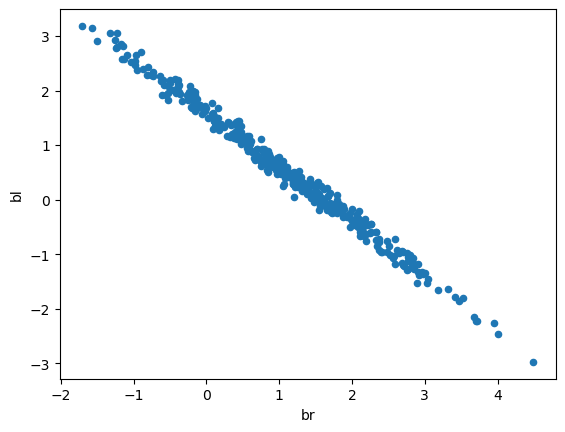

In [19]:
# Scatter plot
posterior_df.plot.scatter(x="br", y="bl")

<Axes: >

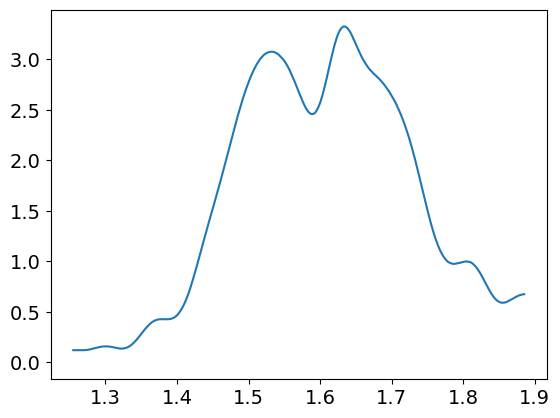

In [23]:
# KDE de suma de posteriores de br y bl
az.plot_kde(posterior_df["br"] + posterior_df["bl"], bw=0.02)

Observamos que la distribución posterior para estos parámetros está altamente **negativamente** correlacionada. Cuando $bl$ es grande, $br$ es pequeña y viceversa.

Obviamente, ambas variables contienen casi la misma información, por lo que si las incluimos ambas en un modelo, existirán prácticamente un número infinito de combinaciones de $bl$ y $br$ sobre la línea que vimos hace un momento, que producirán las mismas predicciones.

Una manera de entender este hecho, es considerar el caso extremo de incluir exactamente el mismo predictor dos veces:

$$
\begin{align}
\begin{array}{ccc}
y_i & \sim & \text{Normal}(\mu_i, \sigma) \\
\mu_i & = & \alpha + \beta_1 x_i + \beta_2 x_i
\end{array}
\end{align}
$$

Observamos que la última línea es equivalente a:

$$
\mu_i = \alpha + (\beta_1 + \beta_2) x_i.
$$

Acá observamos porqué los parámetros $\beta_1$ y $\beta_2$ están tan estrechamente correlacionados. Es imposible que uno por separado influencie a $\mu$; solo su suma, $\beta_1 + \beta_2$ puede hacerlo. Podemos ver esto en la densidad que estimamos.

Ahora, si ajustamos un modelo con una sola de las variables:

In [24]:
# Modelo
with pm.Model() as height_model_left:
    a = pm.Normal("a", mu=1.7, sigma=2)
    bleft = pm.Normal("bl", mu=2, sigma=10)
    sigma = pm.Exponential("sigma", 1)
    mu = a + bleft * left_leg
    height = pm.Normal(
        "height",
        mu=mu,
        sigma=sigma,
        observed=leg_data["height"]
    )
    idata_left = pm.sample(draws=100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bl, sigma]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 4 seconds.


In [25]:
# Summary
az.summary(
    idata_left,
    kind="stats",
    hdi_prob=0.89,
    var_names=["a", "bl", "sigma"]
)

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.444,0.095,0.303,0.600
bl,1.627,0.127,1.422,1.820
sigma,0.092,0.006,0.082,0.101


Observamos que el valor medio de este nuevo $bl$ coincide con el valor medio del $bl+br$ que estimamos en el modelo anterior.

Como conclusión, cuando dos predictores están fuertemente correlacionados, incluir ambos en el modelo puede resultar en confusión. La distribución posterior no va a estar mal, solamente será la respuesta a la pregunta que le hicimos: *¿Cuál es el valor de conocer cada predictor dado que conocemos los demás?*. Cabe decir que el modelo será bueno en cuanto a las predicciones, solamente no podremos interpretar la influencia de cada predictor.

## 2. Ejemplo con datos reales

El ejemplo de las piernas es bastante bueno para entender conceptos, sin embargo, resulta claro que no incluiríamos el tamaño de las dos piernas en un modelo para predecir la altura.

En un escenario real, es más complejo anticipar si dos predictores estarán correlacionados. Incluso predictores que en principio no relacionamos mentalmente, podrían inducir un efecto de multicolinealidad. Como vimos, el problema no está en las predicciones en sí, sino en las interpretaciones que hagamos del modelo.

In [26]:
milk_data.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


En este ejemplo, nos concentraremos en los predictores correspondientes a:

* porcentaje de grasa
* porcentaje de lactosa

para modelar el contenido energético de la leche.

In [27]:
# Standardize function
def standardize(y: pd.Series) -> pd.Series:
    return (y - y.mean()) / y.std()

In [28]:
# Estandarizamos variables
milk_data["energy_std"] = standardize(milk_data["kcal.per.g"])
milk_data["fat_std"] = standardize(milk_data["perc.fat"])
milk_data["lactose_std"] = standardize(milk_data["perc.lactose"])

Comencemos con regresiones bivariadas:

In [29]:
# Modelo con la grasa
with pm.Model() as fat_model:
    a = pm.Normal("a", 0, 0.2)
    bfat = pm.Normal("bf", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    mu = a + bfat * milk_data["fat_std"]
    k = pm.Normal(
        "energy",
        mu,
        sigma,
        observed=milk_data["energy_std"]
    )
    idata_fat = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bf, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [30]:
# Modelo con la lactosa
with pm.Model() as lactose_model:
    a = pm.Normal("a", 0, 0.2)
    blac = pm.Normal("bl", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    mu = a + blac * milk_data["lactose_std"]
    k = pm.Normal(
        "energy",
        mu,
        sigma,
        observed=milk_data["energy_std"]
    )
    idata_lactose = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bl, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [31]:
az.summary(
    idata_fat,
    kind="stats",
    hdi_prob=0.89,
    var_names=["a", "bf", "sigma"]
)

,mean,sd,hdi_5.5%,hdi_94.5%
a,-0.000,0.083,-0.131,0.131
bf,0.858,0.090,0.716,1.004
sigma,0.489,0.068,0.378,0.585


In [32]:
az.summary(
    idata_lactose,
    kind="stats",
    hdi_prob=0.89,
    var_names=["a", "bl", "sigma"]
)

,mean,sd,hdi_5.5%,hdi_94.5%
a,-0.001,0.070,-0.120,0.104
bl,-0.900,0.077,-1.024,-0.780
sigma,0.411,0.059,0.317,0.497


Podemos observar que las posteriores de $bf$ y $bl$ son casi un espejo. Ambas son posteriores estrechas, que yacen de un solo lado del cero, $bf$ en el lado positivo y $bl$ en el lado negativo.

Podríamos concluir que ambas variables son predictores "confiables" del contenido energético de la leche. Sin embargo, veamos que pasa con un modelo con ambos predictores:

In [33]:
# Modelo con ambas variables
with pm.Model() as full_model:
    a = pm.Normal("a", 0, 0.2)
    bfat = pm.Normal("bf", 0, 0.5)
    blac = pm.Normal("bl", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    mu = a + blac * milk_data["lactose_std"] + bfat * milk_data["fat_std"]
    k = pm.Normal(
        "energy",
        mu,
        sigma,
        observed=milk_data["energy_std"]
    )
    idata_full = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bf, bl, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [34]:
# Summary
az.summary(
    idata_full,
    kind="stats",
    hdi_prob=0.89,
    var_names=["a", "bf", "bl", "sigma"]
)

,mean,sd,hdi_5.5%,hdi_94.5%
a,-0.001,0.074,-0.121,0.110
bf,0.256,0.198,-0.058,0.565
bl,-0.664,0.200,-0.991,-0.351
sigma,0.415,0.060,0.319,0.500


Observamos que ahora, las medias de las posteriores de ambos parámetros se movieron hacia cero, e incluso sus desviaciones estándar casi se triplicaron.

Esto es un claro indicativo de que tanto el porcentaje de grasa como el porcentaje de lactosa contienen información similar resepecto al contenido energético de la leche.

In [35]:
import seaborn as sns

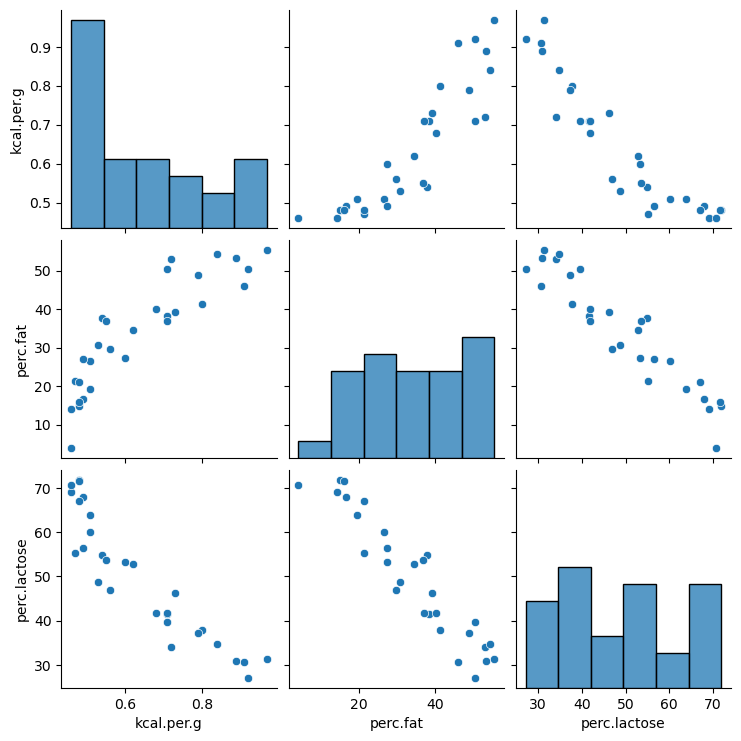

In [36]:
sns.pairplot(
    milk_data[["kcal.per.g", "perc.fat", "perc.lactose"]]
)   

Es decir, cualquiera de las dos puede ser un buen predictor para el contenido energético, pero una vez conoces una, incluir la otra en el modelo no es de mucha ayuda.

**¿Porqué sucede esto?**

Una vez hemos identificado la multicolinealidad, es importante entender qué es lo que la causa. En este ejemplo de la leche, lo que puede estar pasando es que hay un efecto de compensación de una variable con otra.

Si una especie amamanta recurrentemente, la leche tiende a ser "más líquida" y con menos contenido energético. Dicha leche es alta en azucar (lactosa). Por otra parte, si una especia amamanta de forma más esporádica, la leche necesita ser más alta en energía, para lo cual se necesita más grasa.

Esto implica el siguiente modelo:

In [37]:
from causalgraphicalmodels import CausalGraphicalModel
from daft import PGM

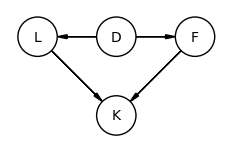

In [38]:
nodes = ["L", "D", "F", "K"]
edges = [("D", "L"), ("D", "F"), ("L", "K"), ("F", "K")]
dag1 = CausalGraphicalModel(nodes=nodes, edges=edges)
pgm1 = PGM()
coordinates = {"L": (0, 0), "D": (1, 0), "F": (2, 0), "K": (1, 1)}
for node in nodes:
    pgm1.add_node(node, node, *coordinates[node])
for edge in edges:
    pgm1.add_edge(*edge)
pgm1.render()
plt.gca().invert_yaxis()

Donde $D$ es una variable no observada que indica qué tan densa debe de ser la leche. Si pudiéramos medir $D$ o tener un modelo para ella, esto sería mejor a intentar diferentes regresiones para ver cuál es mejor.